In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels import api as sm

from statsmodels.tsa.seasonal import STL

from prophet import Prophet

/home/grc/arep/time_series/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Séries temporais de frequência mais alta geralmente exibem padrões sazonais mais complicados. Por exemplo, os dados diários podem ter um padrão semanal e também um padrão anual. Os dados horários geralmente têm três tipos de sazonalidade: um padrão diário, um padrão semanal e um padrão anual. Mesmo os dados semanais podem ser difíceis de prever, pois não há um número inteiro de semanas num ano, pelo que o padrão anual tem um período sazonal de 365,25.

### 1.0. Bank Calls

Esse dataset contem o número de chamadas para um banco comercial norte-americano por intervalo de 5 minutos entre 7h00 e 21h05 todos os dias da semana durante um período de 33 semanas. Há um forte padrão sazonal diário com período 169 (há 169 intervalos de 5 minutos por dia) e um padrão sazonal semanal fraco com período 169 × 5 = 845. (Os volumes de chamadas às segundas-feiras tendem a ser mais elevados do que no resto da semana.) Se uma série mais longa de dados estivesse disponível, também poderíamos ter observado um padrão sazonal anual.

Não queremos necessariamente incluir todos os períodos sazonais possíveis nos nossos modelos, apenas aqueles que provavelmente estarão presentes nos dados. Por exemplo, se tivermos apenas 180 dias de dados, podemos ignorar a sazonalidade anual. Se os dados forem medições de um fenómeno natural (por exemplo, temperatura), provavelmente poderemos ignorar com segurança qualquer sazonalidade semanal.

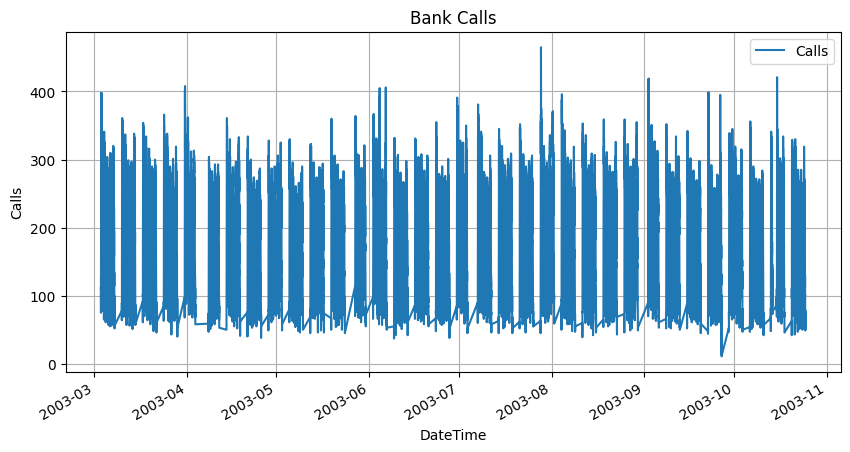

In [3]:
df = pd.read_csv("../data/bank_calls.csv", index_col=[0])

df.DateTime = pd.to_datetime(df.DateTime)

df.plot(x="DateTime", grid=2, figsize=(10, 5), title="Bank Calls", ylabel="Calls");

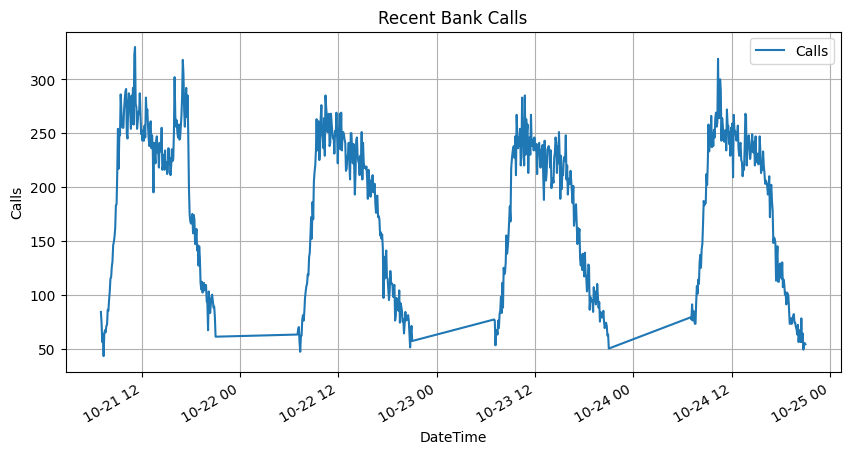

In [4]:
df[df.DateTime >= "2003-10-21"].plot(x="DateTime", y="Calls", ylabel="Calls", figsize=(10, 5), title="Recent Bank Calls", grid=2);

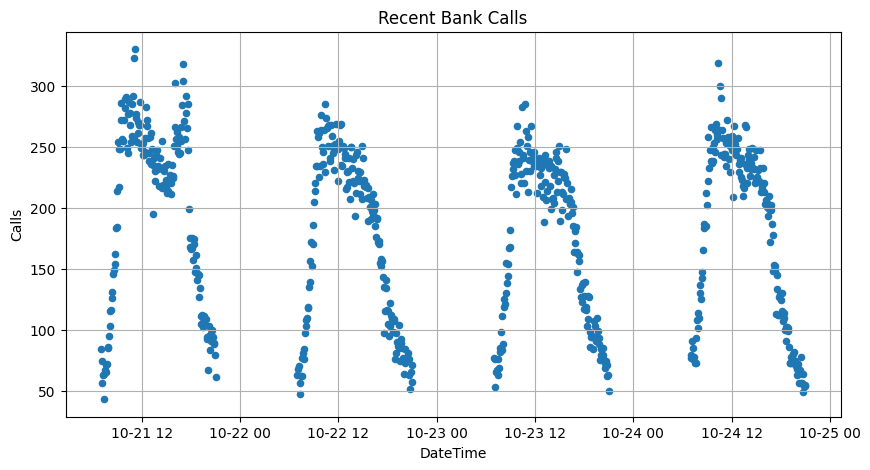

In [5]:
df[df.DateTime >= "2003-10-21"].plot(kind="scatter", x="DateTime", y="Calls", ylabel="Calls", figsize=(10, 5), title="Recent Bank Calls", grid=2);

Além dos múltiplos períodos sazonais, esta série tem a complexidade adicional de valores faltantes entre os períodos de trabalho e também feriados ou dias em que não teve trabalho.

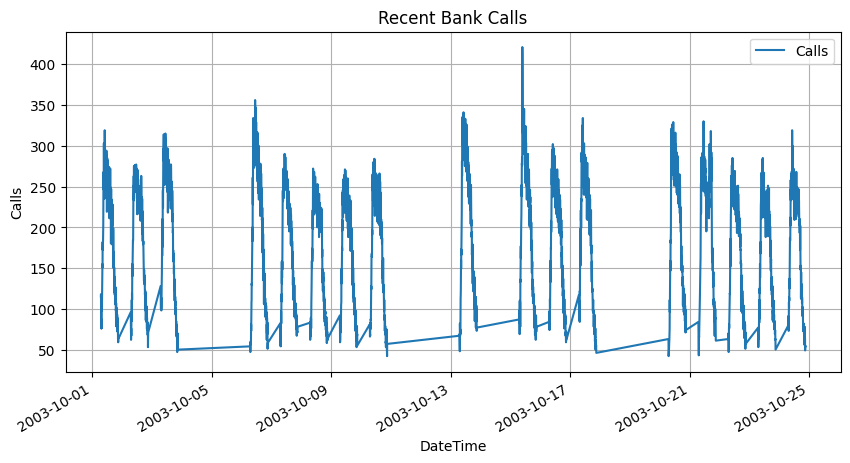

In [6]:
df[df.DateTime >= "2003-10-01"].plot(x="DateTime", y="Calls", ylabel="Calls", figsize=(10, 5), title="Recent Bank Calls", grid=2);

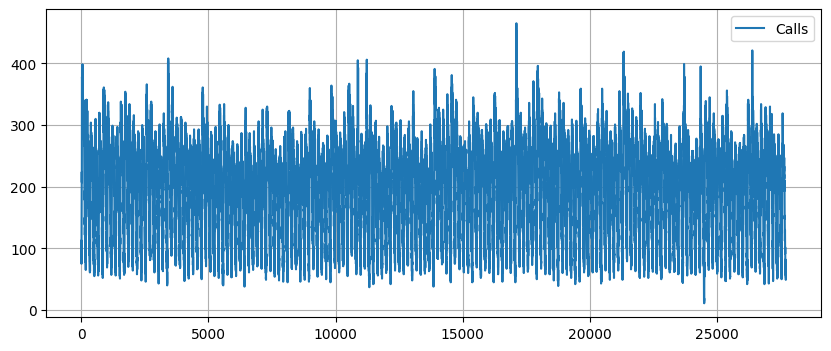

In [7]:
df.plot(y="Calls", grid=2, figsize=(10, 4));

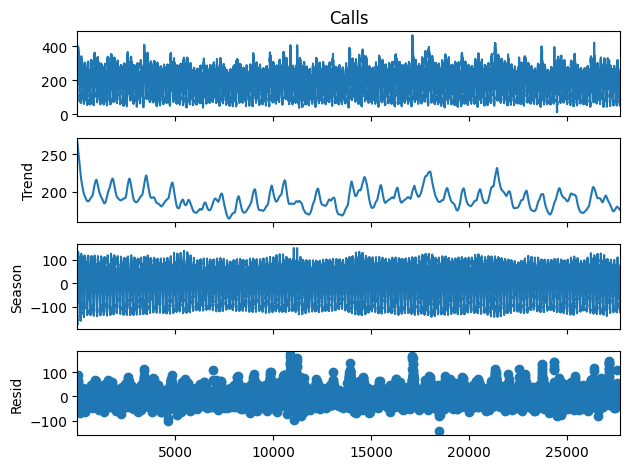

In [15]:
stl = STL(
    df["Calls"],
    robust=True,
    period=169
).fit().plot()

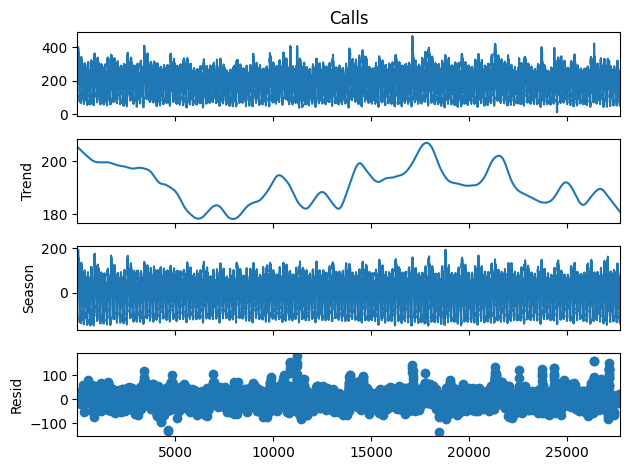

In [16]:
stl = STL(
    df["Calls"],
    robust=True,
    period=169 * 5
).fit().plot()

Fazendo todas essa análises, já poderiamos assumir algumas coisas e considerar um dataset com feriados que seria uma feature chave, pois, se feriado = 0 chadas telefonicas, também precisamos de ferramentas que levem em conta essa sazonalidade complexa.

Infelizmente até onde eu pesquisei, não existe em python a não ser se formos desenvolver do zero os mesmos mecanismos que foram utilizados no livro e em R.

Em resumo, no livro é utilizado três abordagens, a primeira foi atualizar o index da série para remover os valores missing dos perídos onde o banco não trabalha, para gerar o gráfico do último plot.

Com esse dataset, foi utilizado então o Forecast com STL e dois padrões sazonais embutido, após isso foi realizado mais um teste utilizando regressão harmônica sem diferenciação com duas ordens de fourier.

No python tentei iniciar com o primeiro approach, mas estava demorando muito no meu pc, então usei o prophet (abordado posteriormente) e incluir as duas séries de fourier.

In [24]:
df["SqrtCalls"] = np.sqrt(df["Calls"])

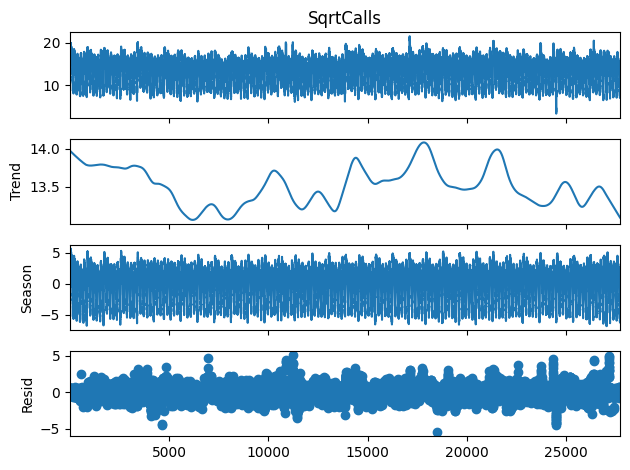

In [35]:
stl_result = STL(
    df["SqrtCalls"],
    period=169 * 5,
    robust=True
).fit()

df["seasonal_adj"] = df["Calls"] / (stl_result.seasonal ** 2)

stl_result.plot();

In [ ]:
#ets = sm.tsa.ETSModel(
#    df["seasonal_adj"],
#    error="add",
#    trend="add",
#    seasonal="add",
#    seasonal_periods=169,
#).fit(disp=0)
#
#ets.summary()

In [ ]:
#ets = sm.tsa.ETSModel(
#    df["Calls"],
#    error="add",
#    trend="add",
#    seasonal="add",
#    seasonal_periods=169,
#).fit(disp=0)
#
#ets.summary()

In [ ]:
#ets = sm.tsa.ETSModel(
#    df["SqrtCalls"],
#    error="add",
#    trend="add",
#    seasonal="add",
#    seasonal_periods=169,
#).fit(disp=0)
#
#ets.summary()

Utilizando o prophet e incluindo as duas séries de fourier.

Entretanto não é a versão re-indexada, e sim o dataset "cru" mesmo.

In [17]:
df.columns = ["ds", "y"]

In [18]:
p = Prophet()

# Add Fourier order seasonality with a period of 169 and K = 10
p.add_seasonality(name='season_169', period=169, fourier_order=10)

# Add Fourier order seasonality with a period of 5 * 169 and K = 5
p.add_seasonality(name='season_5_169', period=5 * 169, fourier_order=5)

p.fit(df)

07:50:51 - cmdstanpy - INFO - Chain [1] start processing
07:51:23 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
forecast = df[df.ds >= df.ds.dt.normalize().max() - pd.offsets.DateOffset(days=5)].copy()

forecast.reset_index(inplace=True, drop=True)
forecast.drop(columns=["y"], inplace=True)

forecast["ds"] = forecast["ds"] + pd.offsets.DateOffset(weeks=1)

forecast = p.predict(forecast)[["ds", "yhat_lower", "yhat_upper", "yhat"]]

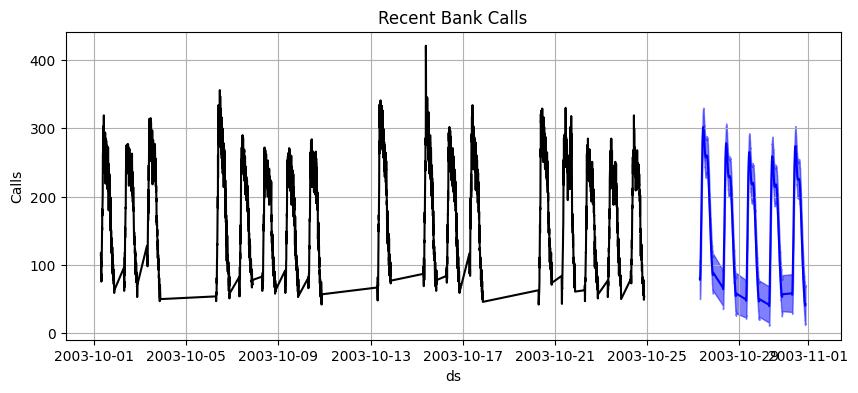

In [67]:
dfp = df[df.ds >= "2003-10-01"]

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(forecast, x="ds", y="yhat", color="b", ax=ax);
sns.lineplot(dfp, x="ds", y="y", color="k", ax=ax)
ax.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="b", alpha=0.5)

ax.set_ylabel("Calls")
ax.set_title("Recent Bank Calls")
ax.grid(2)